<a href="https://colab.research.google.com/github/Ankan1998/Text-GCN/blob/main/text_gcn_with_understandable_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

## Importing dataset

In [2]:
# Ankan:0, Segui:1
X=["Ankan is a good boy",
   "Segui is a bad boy",
   "Ankan loves food",
   "Ankan is good in sports",
   "Segui is bad in sports"]
Y=[0,1,0,0,1]


## Cleaning Dataset

In [3]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

re_url = re.compile(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
re_email = re.compile('(?:[a-z0-9!#$%&\'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])')

In [4]:
def clean_header(text):
    text = re.sub(r'(From:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Subject:[^\n]+\n)', '', text)
    text = re.sub(r'(([\sA-Za-z0-9\-]+)?[A|a]rchive-name:[^\n]+\n)', '', text)
    text = re.sub(r'(Last-modified:[^\n]+\n)', '', text)
    text = re.sub(r'(Version:[^\n]+\n)', '', text)

    return text



In [5]:
for i in range(len(X)):
  X[i]=clean_header(X[i])

In [6]:
X

['Ankan is a good boy',
 'Segui is a bad boy',
 'Ankan loves food',
 'Ankan is good in sports',
 'Segui is bad in sports']

In [7]:
def clean_text(text):        
    text = text.lower()
    text = text.strip()
    text = re.sub(re_url, '', text)
    text = re.sub(re_email, '', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'(\d+)', ' ', text)
    text = re.sub(r'(\s+)', ' ', text)
    
    return text



In [8]:
for i in range(len(X)):
  X[i]=clean_text(X[i])

In [9]:
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def rem_stopwords(dataset,stop_words):
  for i in range(len(dataset)):
    temp=[]
    for word in dataset[i].split(" "):
      
      if word not in stop_words:
        temp.append(word)
    p=" ".join(temp)
    dataset[i]=p
  return dataset

In [11]:
X=rem_stopwords(X,stop_words)

In [12]:
X

['ankan good boy',
 'segui bad boy',
 'ankan loves food',
 'ankan good sports',
 'segui bad sports']

# **GCN preprocessing**

## TFIDF Vectorizing

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
# Top max features are taken
vectorizer = TfidfVectorizer(input="content",max_features=None)
vectors = vectorizer.fit_transform(X)

In [15]:
vectors

<5x8 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [16]:
df_tfidf = vectors.toarray()
top_words = vectorizer.get_feature_names()
top_words = np.array(top_words)
df_tfidf = pd.DataFrame(df_tfidf,columns=top_words)

In [17]:
X

['ankan good boy',
 'segui bad boy',
 'ankan loves food',
 'ankan good sports',
 'segui bad sports']

In [18]:
df_tfidf

,ankan,bad,boy,food,good,loves,segui,sports
0,0.506204,0.00000,0.609818,0.00000,0.609818,0.00000,0.00000,0.000000
1,0.000000,0.57735,0.577350,0.00000,0.000000,0.00000,0.57735,0.000000
2,0.427993,0.00000,0.000000,0.63907,0.000000,0.63907,0.00000,0.000000
3,0.506204,0.00000,0.000000,0.00000,0.609818,0.00000,0.00000,0.609818
4,0.000000,0.57735,0.000000,0.00000,0.000000,0.00000,0.57735,0.577350


## Point-wise Mutual Information

In [19]:
from collections import OrderedDict
from tqdm import tqdm

In [20]:
### PMI between words
window = 2 # sliding window size to calculate point-wise mutual information between words
names = top_words
ncount  = OrderedDict((name, 0) for name in names)
word_index = OrderedDict((name,index) for index,name in enumerate(names))


In [21]:
occ = np.zeros( (len(names),len(names)) ,dtype=np.int32)

In [22]:
# Find the co-occurrences:
# Will take huge tim, so saved as co_mat1000.npy file
from itertools import combinations
no_windows = 0
# taking each data from dataset
for l in tqdm(X,total=len(X)):
    # Iterating over each word in the line "l"
    for i in range(len(l.split(" "))-window):
        # Counting windows
        no_windows += 1
        # Getting unique words within the window
        d = set(l.split(" ")[i:(i+window)])
        d=d.intersection(set(names))
        # Counting occurrences of each word on whole document "ncount"
        for w in d:
            ncount[w] += 1
        # Combination of two words 
        for w1,w2 in combinations(d,2):
            i1 = word_index[w1]
            i2 = word_index[w2]
            # Counting word-word
            occ[i1][i2] += 1
            occ[i2][i1] += 1
    

100%|██████████| 5/5 [00:00<00:00, 6736.76it/s]


In [23]:
word_index

OrderedDict([('ankan', 0),
             ('bad', 1),
             ('boy', 2),
             ('food', 3),
             ('good', 4),
             ('loves', 5),
             ('segui', 6),
             ('sports', 7)])

In [24]:
occ

array([[0, 0, 0, 0, 2, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [25]:
# convert to PMI
import math
p_i_j = pd.DataFrame(occ, index = names,columns=names)/no_windows
p_i = pd.Series(ncount, index=ncount.keys())/no_windows

In [26]:
p_i

ankan     0.6
bad       0.4
boy       0.0
food      0.0
good      0.4
loves     0.2
segui     0.4
sports    0.0
dtype: float64

In [27]:
for col in p_i_j.columns:
    p_i_j[col] = p_i_j[col]/p_i[col]
for row in p_i_j.index:
    p_i_j.loc[row,:] = p_i_j.loc[row,:]/p_i[row]
p_i_j = p_i_j + 1E-9
for col in p_i_j.columns:
    p_i_j[col] = p_i_j[col].apply(lambda x: math.log(x))

In [28]:
p_i_j

,ankan,bad,boy,food,good,loves,segui,sports
ankan,-20.723266,-20.723266,NaN,NaN,0.510826,0.510826,-20.723266,NaN
bad,-20.723266,-20.723266,NaN,NaN,-20.723266,-20.723266,0.916291,NaN
boy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
good,0.510826,-20.723266,NaN,NaN,-20.723266,-20.723266,-20.723266,NaN
loves,0.510826,-20.723266,NaN,NaN,-20.723266,-20.723266,-20.723266,NaN
segui,-20.723266,0.916291,NaN,NaN,-20.723266,-20.723266,-20.723266,NaN
sports,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
from itertools import combinations
def word_word_edges(p_i_j):
    word_word = []
    cols = list(p_i_j.columns)
    cols = [str(w) for w in cols]
    for w1, w2 in tqdm(combinations(cols, 2)):
        if (p_i_j.loc[w1,w2] > 0):
            word_word.append((w1,w2,{"weight":p_i_j.loc[w1,w2]}))
    return word_word

In [30]:
import networkx as nx
### Build graph
G = nx.Graph()
G.add_nodes_from(df_tfidf.index) ## document nodes
G.add_nodes_from(top_words) ## word nodes
### build edges between document-word pairs
document_word = [(doc,w,{"weight":df_tfidf.loc[doc,w]}) for doc in df_tfidf.index for w in df_tfidf.columns]
G.add_edges_from(document_word)
### build edges between word-word pairs
word_word = word_word_edges(p_i_j)
G.add_edges_from(word_word)

28it [00:00, 9427.67it/s]


In [31]:
document_word

[(0, 'ankan', {'weight': 0.5062044059286201}),
 (0, 'bad', {'weight': 0.0}),
 (0, 'boy', {'weight': 0.6098184563533858}),
 (0, 'food', {'weight': 0.0}),
 (0, 'good', {'weight': 0.6098184563533858}),
 (0, 'loves', {'weight': 0.0}),
 (0, 'segui', {'weight': 0.0}),
 (0, 'sports', {'weight': 0.0}),
 (1, 'ankan', {'weight': 0.0}),
 (1, 'bad', {'weight': 0.5773502691896257}),
 (1, 'boy', {'weight': 0.5773502691896257}),
 (1, 'food', {'weight': 0.0}),
 (1, 'good', {'weight': 0.0}),
 (1, 'loves', {'weight': 0.0}),
 (1, 'segui', {'weight': 0.5773502691896257}),
 (1, 'sports', {'weight': 0.0}),
 (2, 'ankan', {'weight': 0.42799292268317357}),
 (2, 'bad', {'weight': 0.0}),
 (2, 'boy', {'weight': 0.0}),
 (2, 'food', {'weight': 0.6390704413963749}),
 (2, 'good', {'weight': 0.0}),
 (2, 'loves', {'weight': 0.6390704413963749}),
 (2, 'segui', {'weight': 0.0}),
 (2, 'sports', {'weight': 0.0}),
 (3, 'ankan', {'weight': 0.5062044059286201}),
 (3, 'bad', {'weight': 0.0}),
 (3, 'boy', {'weight': 0.0}),
 (3,

In [32]:
word_word

[('ankan', 'good', {'weight': 0.5108256243659908}),
 ('ankan', 'loves', {'weight': 0.5108256243659908}),
 ('bad', 'segui', {'weight': 0.9162907322741551})]

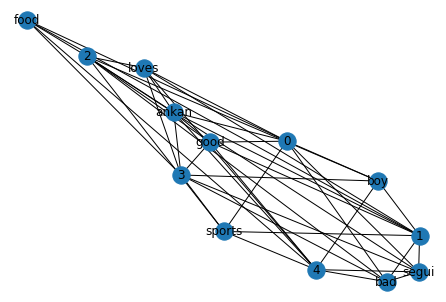

In [33]:
nx.draw(G,with_labels = True)

In [34]:
import networkx as nx
# Adjaceny matrix of G
A = nx.to_numpy_matrix(G, weight="weight") 
# A=A+I
A = A + np.eye(G.number_of_nodes())
# Creating degree matrix
degrees = []
for d in G.degree(weight=None):
    if d == 0:
        degrees.append(0)
    else:
        degrees.append(d[1]**(-0.5))
degrees = np.diag(degrees)
X = np.eye(G.number_of_nodes()) # Features are just identity matrix
# Normalized Laplacian 
A_hat = degrees@A@degrees
f = X 


In [36]:
A_hat.shape

(13, 13)

In [37]:
X

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

## Pytorch Model

In [40]:
# Simplified GCN 
import torch
import torch.nn as nn
import torch.nn.functional as F
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, acti=True):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim) # bias = False 
        if acti:
            self.acti = nn.ReLU(inplace=True)
        else:
            self.acti = None
    def forward(self, F):
        output = self.linear(F)
        if not self.acti:
            return output
        return self.acti(output)


class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, p):
        super(GCN, self).__init__()
        self.gcn_layer1 = GCNLayer(input_dim, hidden_dim)
        self.gcn_layer2 = GCNLayer(hidden_dim, num_classes, acti=False)
        self.dropout = nn.Dropout(p)

    def forward(self, A, X):
        A = torch.tensor(A, requires_grad=False).float()
        F = torch.mm(A, X)
        F = self.gcn_layer1(F)
        F = self.dropout(F)
        F = torch.mm(A, F)
        output = self.gcn_layer2(F)
        return output

In [52]:
net1 = GCN(X.shape[1], hidden_dim=20,num_classes=2,p=0.1)

In [53]:
lr=0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net1.parameters(), lr=lr)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
net1=net1.to(device)

In [45]:
# transforming from numpy array to tensor
f = torch.from_numpy(f).float()
Y=torch.FloatTensor(Y)

In [54]:
# Training
num_epochs=100
losses_per_epoch=[]
for epoch in range(num_epochs):
    output = net1(A_hat,f)
    labels = Y.to(dtype=torch.long)
    loss = criterion(output[:5,:], torch.tensor(labels[:5]))
    losses_per_epoch.append(loss.item())
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.6637
Epoch [20/100], Loss: 0.6248
Epoch [30/100], Loss: 0.5779
Epoch [40/100], Loss: 0.4903
Epoch [50/100], Loss: 0.4100
Epoch [60/100], Loss: 0.2922
Epoch [70/100], Loss: 0.2189
Epoch [80/100], Loss: 0.1489
Epoch [90/100], Loss: 0.0873
Epoch [100/100], Loss: 0.0754


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


# Citation


SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS

ThomasN.Kipf University of Amsterdam T.N.Kipf@uva.nl
MaxWelling University of Amsterdam Canadian Institute for Advanced Research (CIFAR) M.Welling@uva.nl
***********************************************************************
GraphConvolutionalNetworksforTextClassiﬁcation

LiangYao,ChengshengMao,YuanLuo∗ Northwestern University Chicago IL 60611 {liang.yao, chengsheng.mao, yuan.luo}@northwestern.edu

************************************************************************
